# Tree species classification project -- Data Science of Earth Oberservation
Group members:


Input file: .npy

In [1]:
# import the libraries you need

import os
import math
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from matplotlib.image import imread
from itertools import product
from PIL import Image
from itertools import chain
import json
from jsonpath import jsonpath 

from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import type_of_target

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import torch
# Folium setup.
import folium

# Step 1. Input the npy data

In [11]:
# get all npy files
## The ratio can also be changed
path= '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Data science of earth observation/Project_data_science/data0121/npy/'
split_ratio = 0.8
dir_samples = path + "/*.npy"
samples = glob.glob(dir_samples)

# merge them
t_samples = np.load(samples[0], allow_pickle=True)

for i, p in tqdm(enumerate(samples[1:])):
    try:
        t_samples = np.concatenate(
            (t_samples, np.load(p, allow_pickle=True))
        )
    except Exception:
        print(p)
        
np.random.shuffle(t_samples,)

train_num = int(len(t_samples)*split_ratio)

t_sample = t_samples[:train_num]
v_sample = t_samples[train_num:]


# define the train/valid path
t_samples_merge_path = path + "merge/train_merge.npy"
v_samples_merge_path = path + "merge/val_merge.npy"

np.save(t_samples_merge_path, t_sample)
np.save(v_samples_merge_path, v_sample)

print("Now all merge samples are saved!")

6it [00:00, 74.70it/s]

Now all merge samples are saved!


# Step 2. Data preparation

In [12]:
train_merge = np.load(t_samples_merge_path,allow_pickle=True)
val_merge = np.load(v_samples_merge_path,allow_pickle=True)
print (np.array(train_merge).shape)
print (np.array(val_merge).shape)

(2547, 1, 2)
(637, 1, 2)


In [13]:
kernel=9
bands=40
output_size = 8
number_samples = train_merge.shape[0]
data_train = train_merge[:,:,0]

X_train= np.zeros((number_samples,  kernel,kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train[i,:] = data_train[i,0]

Y_train = np.reshape(train_merge[:,:,1],number_samples).astype(int)



In [14]:

number_samples = val_merge.shape[0]
data_val = val_merge[:,:,0]
X_val= np.zeros((number_samples,   kernel,kernel,bands), dtype=float)

for i in range(0,number_samples-1):
    X_val[i,:] = data_val[i,0]

Y_val = np.reshape(val_merge[:,:,1],number_samples).astype(int)

In [15]:
number_samples = X_train.shape[0]
X_train_rf = np.reshape(X_train, (number_samples,  kernel*kernel*bands))
X_train_rf= np.array(pd.DataFrame(X_train_rf).fillna(0))
print("Post-processed S2_train data shape: ", X_train_rf.shape)

Post-processed S2_train data shape:  (2547, 3240)


In [16]:
number_samples_v = X_val.shape[0]
X_val_rf = np.reshape(X_val, (number_samples_v, kernel*kernel*bands))
X_val_rf= np.array(pd.DataFrame(X_val_rf).fillna(0))
print("Post-processed S2_val data shape: ", X_val_rf.shape)

Post-processed S2_val data shape:  (637, 3240)


# Step 3. Random forest classification

Random Forest: Random Forest is a supervised learning algorithm, it can be used to classify tree species using Sentinel-2 imagery.

In [17]:
rf_classifier = RandomForestClassifier(random_state=0)

rf_classifier.fit(X_train_rf, Y_train)

RandomForestClassifier(random_state=0)

In [18]:
y_pred_rf = rf_classifier.predict(X_val_rf)

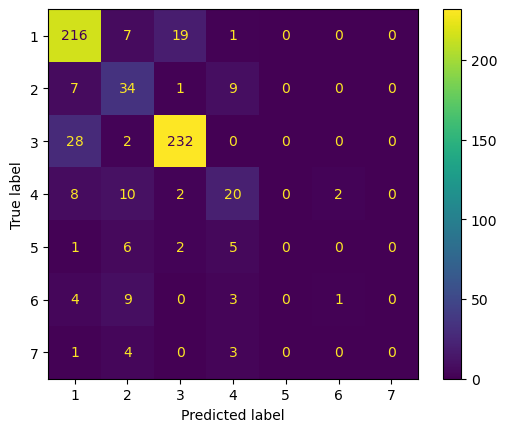

Accuracy Random Forest Classifier:  0.7896389324960753


In [19]:
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rf)
plt.show()

acc_rf = accuracy_score(Y_val, y_pred_rf)
print("Accuracy Random Forest Classifier: ", acc_rf)

# Step 4. Artificial Nueral Network (ANN) classification

In [118]:
number_samples = X_train.shape[0]
X_train_nn= np.zeros((number_samples,  kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train_nn[i,:] = np.reshape(X_train[i,:], (  kernel*kernel,bands))
    X_train_nn[i,:]= np.array(pd.DataFrame(X_train_nn[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_train_nn.shape)

Post-processed S2_train data shape:  (2547, 81, 40)


In [102]:
number_samples = X_train.shape[0]
X_train_nn0= np.zeros((number_samples,  kernel,4,kernel,bands), dtype=float)
X_train_nn1= np.zeros((number_samples,  kernel*4,kernel,4,bands), dtype=float)
X_train_nn2= np.zeros((number_samples,  kernel*4,kernel,bands), dtype=float)
X_train_nn3= np.zeros((number_samples,  kernel*4,kernel*4,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train_nn0[i,:] = np.stack((np.array(X_train[i,:]),np.array(X_train[i,:]),np.array(X_train[i,:]),np.array(X_train[i,:])),axis=1)
    X_train_nn2[i,:] = np.reshape(X_train_nn0[i,:], (  kernel*4,kernel,bands))
    X_train_nn1[i,:] = np.stack((np.array(X_train_nn2[i,:]),np.array(X_train_nn2[i,:]),np.array(X_train_nn2[i,:]),np.array(X_train_nn2[i,:])),axis=2)
    
    X_train_nn3[i,:] = np.reshape(X_train_nn1[i,:], (  kernel*4,kernel*4,bands))
   # X_train_nn2[i,:]= np.array(pd.DataFrame(X_train_nn2[i,:]).fillna(0))
    #X_train_nn2[i,:]= np.array(pd.DataFrame(X_train_nn2[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_train_nn3.shape)

Post-processed S2_train data shape:  (2547, 36, 36, 40)


In [103]:
number_samples = X_val.shape[0]
X_val_nn0= np.zeros((number_samples,  kernel,4,kernel,bands), dtype=float)
X_val_nn1= np.zeros((number_samples,  kernel*4,kernel,4,bands), dtype=float)
X_val_nn2= np.zeros((number_samples,  kernel*4,kernel,bands), dtype=float)
X_val_nn3= np.zeros((number_samples,  kernel*4,kernel*4,bands), dtype=float)
for i in range(0,number_samples-1):
    X_val_nn0[i,:] = np.stack((np.array(X_val[i,:]),np.array(X_val[i,:]),np.array(X_val[i,:]),np.array(X_val[i,:])),axis=1)
    X_val_nn2[i,:] = np.reshape(X_val_nn0[i,:], (  kernel*4,kernel,bands))
    X_val_nn1[i,:] = np.stack((np.array(X_val_nn2[i,:]),np.array(X_val_nn2[i,:]),np.array(X_val_nn2[i,:]),np.array(X_val_nn2[i,:])),axis=2)
    
    X_val_nn3[i,:] = np.reshape(X_val_nn1[i,:], (  kernel*4,kernel*4,bands))
   # X_train_nn2[i,:]= np.array(pd.DataFrame(X_train_nn2[i,:]).fillna(0))
    #X_train_nn2[i,:]= np.array(pd.DataFrame(X_train_nn2[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_val_nn3.shape)

Post-processed S2_train data shape:  (637, 36, 36, 40)


In [112]:
input_size=( kernel*kernel,bands)

In [117]:
number_samples = X_val.shape[0]
X_val_nn= np.zeros((number_samples,   kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_val_nn[i,:] = np.reshape(X_val[i,:], (  kernel*kernel,bands))
    X_val_nn[i,:]= np.array(pd.DataFrame(X_val_nn[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_val_nn.shape)

Post-processed S2_train data shape:  (637, 81, 40)


In [123]:
simple_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=input_size),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(output_size, activation='softmax')
])

simple_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [124]:
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

In [125]:
history = simple_model.fit(X_train_nn, Y_train, epochs=200,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20)],  verbose=0,validation_data=(X_val_nn, Y_val))

Epoch 1/200


2023-01-25 02:39:16.950754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 02:39:19.564988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 3s 44ms/sample - loss: 1.2835 - accuracy: 0.5159 - val_loss: 0.9939 - val_accuracy: 0.6044
Epoch 21/200
80/80 [==============================] - 2s 21ms/sample - loss: 0.7212 - accuracy: 0.7314 - val_loss: 0.7601 - val_accuracy: 0.7331
Epoch 41/200
80/80 [==============================] - 0s 6ms/sample - loss: 0.6417 - accuracy: 0.7636 - val_loss: 0.7165 - val_accuracy: 0.7520
Epoch 61/200
80/80 [==============================] - 0s 6ms/sample - loss: 0.5810 - accuracy: 0.7872 - val_loss: 0.7046 - val_accuracy: 0.7567
Epoch 81/200
80/80 [==============================] - 0s 6ms/sample - loss: 0.5339 - accuracy: 0.8033 - val_loss: 0.7343 - val_accuracy: 0.7582
Epoch 101/200
80/80 [==============================] - 0s 6ms/sample - loss: 0.5087 - accuracy: 0.8045 - val_loss: 0.7447 - val_accuracy: 0.7316
Epoch 121/200
80/80 [==============================] - 0s 6ms/sample - loss: 0.4401 - accuracy: 0.8378 - val_loss: 0.7310 - val_accuracy: 0.7473
E

In [126]:
y_pred_dl_p = simple_model.predict(X_val_nn)

print("Prediction example: ", y_pred_dl_p[0,:], " Class: ", np.argmax(y_pred_dl_p[0,:]))

20/20 [==============================] - 0s 4ms/step
Prediction example:  [1.03113305e-08 4.16543894e-03 3.13807994e-01 8.63937254e-04
 2.11264223e-01 1.65504187e-01 1.53840229e-01 1.50553957e-01]  Class:  2


2023-01-25 03:07:20.231270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


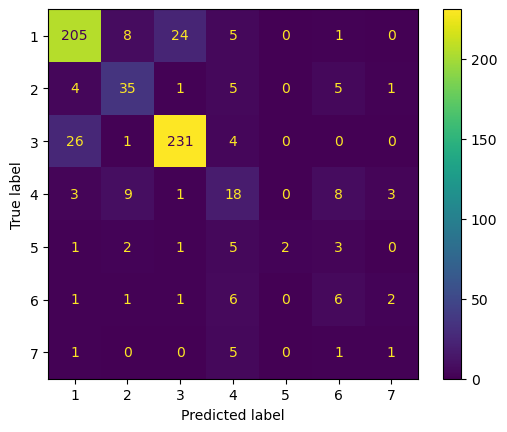

Accuracy Simple Deep Learning model:  0.7817896389324961


In [127]:
y_pred_dl = np.argmax(y_pred_dl_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_dl)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_dl)
print("Accuracy Simple Deep Learning model: ", acc_dl)

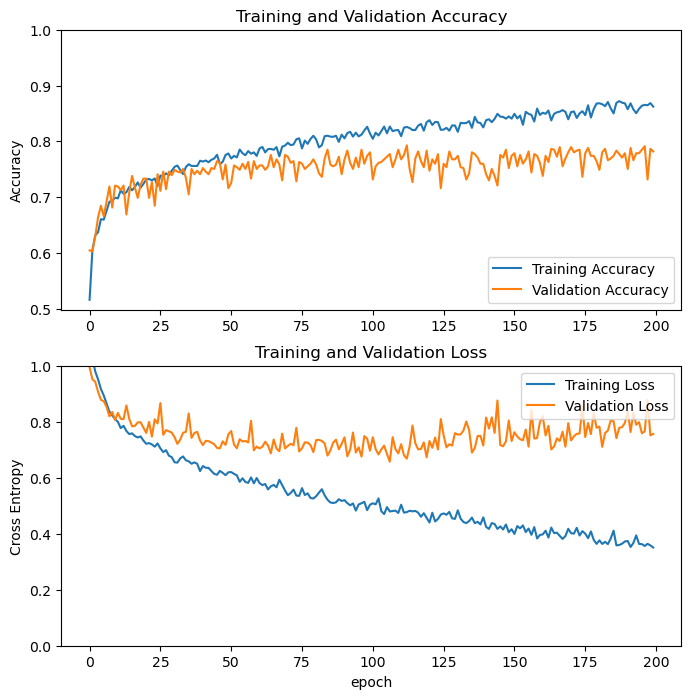

In [128]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [129]:
fine_tune_epochs = 200
initial_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = simple_model.fit(X_train_nn,Y_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(X_val_nn,Y_val))

Epoch 200/210
80/80 [==============================] - 1s 8ms/step - loss: 0.3527 - accuracy: 0.8771 - val_loss: 0.8451 - val_accuracy: 0.7755
Epoch 201/210
80/80 [==============================] - 1s 7ms/step - loss: 0.3580 - accuracy: 0.8712 - val_loss: 0.8083 - val_accuracy: 0.7865
Epoch 202/210
80/80 [==============================] - 1s 7ms/step - loss: 0.3770 - accuracy: 0.8606 - val_loss: 0.8274 - val_accuracy: 0.7630
Epoch 203/210
80/80 [==============================] - 1s 7ms/step - loss: 0.3732 - accuracy: 0.8606 - val_loss: 0.7609 - val_accuracy: 0.7739
Epoch 204/210
80/80 [==============================] - 1s 7ms/step - loss: 0.3530 - accuracy: 0.8673 - val_loss: 0.7562 - val_accuracy: 0.7896
Epoch 205/210
80/80 [==============================] - 1s 7ms/step - loss: 0.3569 - accuracy: 0.8649 - val_loss: 0.7849 - val_accuracy: 0.7959
Epoch 206/210
80/80 [==============================] - 1s 7ms/step - loss: 0.3407 - accuracy: 0.8697 - val_loss: 0.7914 - val_accuracy: 0.7724

In [130]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

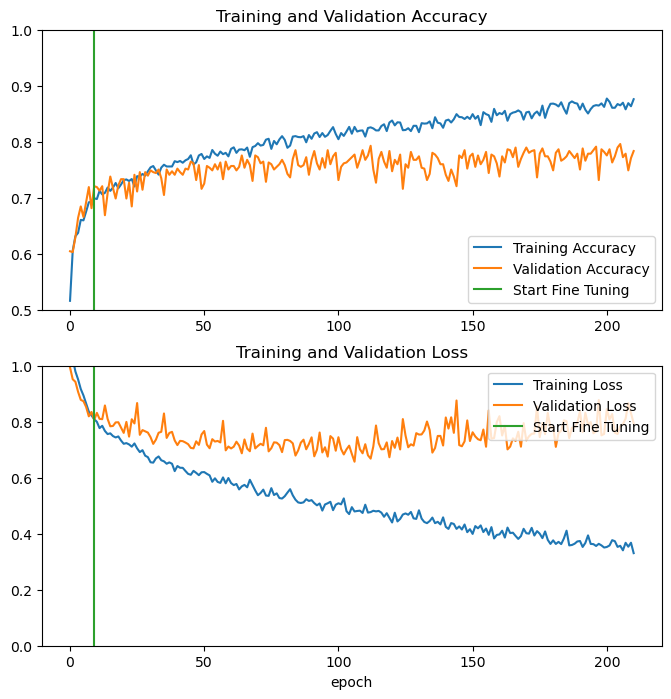

In [131]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [132]:
loss, accuracy = simple_model.evaluate(X_val_nn,Y_val)
print('Test accuracy :', accuracy)

20/20 [==============================] - 0s 6ms/step - loss: 0.7946 - accuracy: 0.7834
Test accuracy : 0.7833595275878906


# Step 5. Convolutional Neural Networks (CNNs) classification

Convolutional Neural Networks (CNNs): These are commonly used for image classification tasks and have been shown to be effective for tree species classification using Sentinel-2 imagery.

In [32]:
CNNs_model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu",input_shape=(kernel*kernel,bands,1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16)
]
)

In [33]:

CNNs_model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 81, 40, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 20, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 20, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [34]:

CNNs_model.add(layers.Flatten())
CNNs_model.add(layers.Dense(64, activation='relu'))
CNNs_model.add(layers.Dense(output_size))

In [35]:

CNNs_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 81, 40, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 20, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 20, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [36]:

CNNs_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = CNNs_model.fit(X_train_nn, Y_train, epochs=40,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20)],  verbose=0,
                    validation_data=(X_val_nn, Y_val))
     

Epoch 1/40


2023-01-22 05:11:00.283025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-22 05:11:02.368606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 3s 33ms/sample - loss: 1.3721 - accuracy: 0.4295 - val_loss: 0.9466 - val_accuracy: 0.6327
Epoch 21/40
80/80 [==============================] - 2s 22ms/sample - loss: 0.5448 - accuracy: 0.7947 - val_loss: 0.6125 - val_accuracy: 0.7975


In [37]:
y_pred_cnn_p = CNNs_model.predict(X_val_nn)

print("Prediction example: ", y_pred_cnn_p[0,:], " Class: ", np.argmax(y_pred_cnn_p[0,:]))

 2/20 [==>...........................] - ETA: 1s

2023-01-22 05:18:31.368260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 0s 12ms/step
Prediction example:  [-9.717025   -2.6211083   2.4408605  -3.0726461  -0.12619185  1.0404273
  0.25033367 -0.7285453 ]  Class:  2


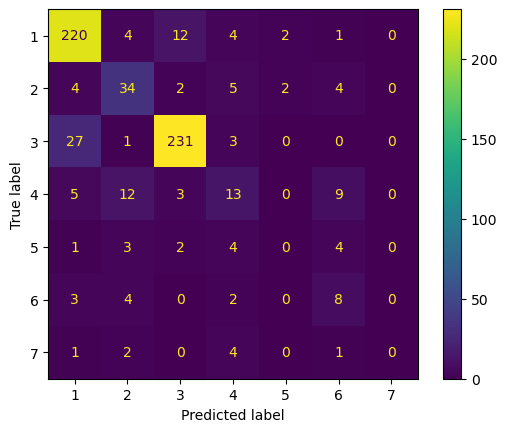

Accuracy Simple Deep Learning model:  0.7943485086342229


In [38]:
y_pred_cnn = np.argmax(y_pred_cnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_cnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_cnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

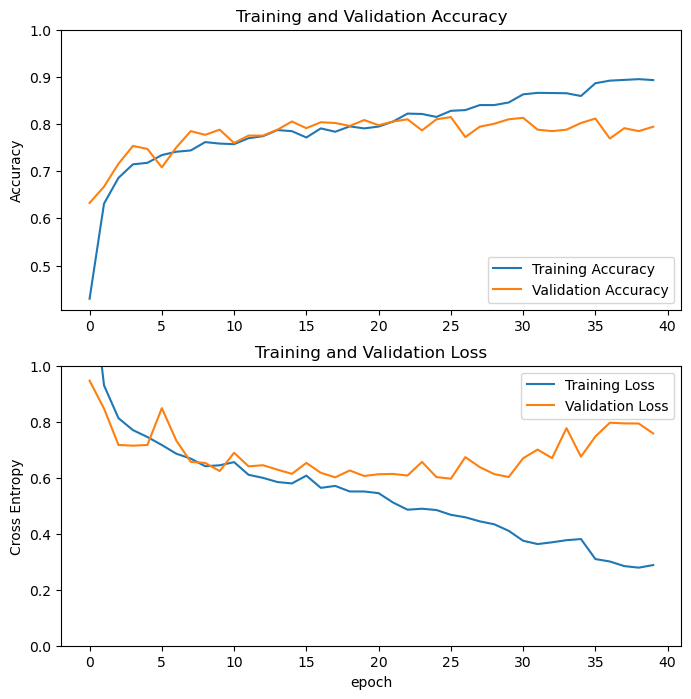

In [39]:

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Step 6. - Residual Network: ResNet

A residual neural network (ResNet) is an artificial neural network that imitate the pyramidal cells in the cerebral cortex. Particularly, the ResNet architecture consists of skip connections or shortcuts to jump over some layers. Typical ResNet models are implemented with double- or triple- layer skips that contain nonlinearities (ReLU) and batch normalization in between. These *cells* are known as *residual block*.

ResNets connection weights are easier to optimize (especially for gradient descent-based optimizers) because the short cuts contribute to alleviate the vanishing gradient problem.

In practice, the degradation problem (i.e., increasing the depth of a network leads to a decrease in its performance) is mitigated, and the observed performance (when the number of hidden layers increase) is much closer to the theoretical one.

In [59]:
model_rn = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(  kernel*kernel,bands,1), 
    pooling=None,
    classes=output_size)

model_rn.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

In [60]:
history3=model_rn.fit(X_train_nn, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20)],  verbose=0,validation_data=(X_val_nn, Y_val))


Epoch 1/100


2023-01-23 18:09:05.785850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-23 18:09:23.590307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 22s 276ms/sample - loss: 1.6424 - accuracy: 0.6180 - val_loss: 1.7864 - val_accuracy: 0.3815
Epoch 21/100
80/80 [==============================] - 7s 93ms/sample - loss: 0.4730 - accuracy: 0.8261 - val_loss: 0.7601 - val_accuracy: 0.7755
Epoch 41/100
80/80 [==============================] - 7s 93ms/sample - loss: 0.5218 - accuracy: 0.8170 - val_loss: 1.3637 - val_accuracy: 0.5526
Epoch 61/100
80/80 [==============================] - 7s 92ms/sample - loss: 0.3294 - accuracy: 0.8685 - val_loss: 0.9389 - val_accuracy: 0.7331
Epoch 81/100
80/80 [==============================] - 7s 94ms/sample - loss: 0.1356 - accuracy: 0.9564 - val_loss: 1.7867 - val_accuracy: 0.7378


2023-01-24 17:40:35.767961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 3s 63ms/step


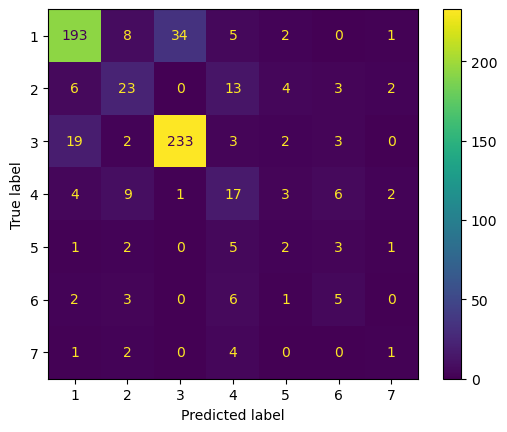

Accuracy ResNet-50 model:  0.7441130298273155


In [61]:
y_pred_rn_p = model_rn.predict(X_val_nn)

y_pred_rn = np.argmax(y_pred_rn_p, axis=1)

##print(y_pred_rn)
#print(Y_val)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rn)
plt.show()

acc_rn = accuracy_score(Y_val, y_pred_rn)
print("Accuracy ResNet-50 model: ", acc_rn)

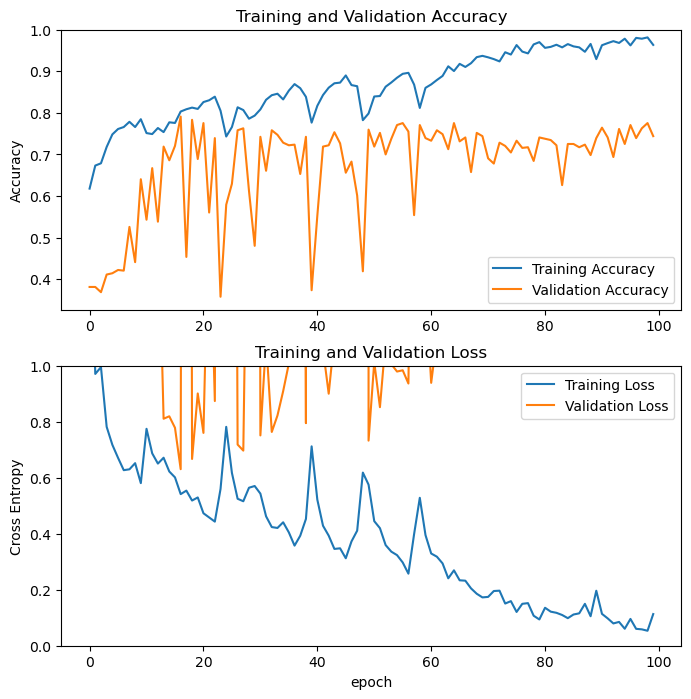

In [62]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [104]:

inputs = tf.keras.layers.Input(shape=(input_size[0], input_size[1],input_size[2]), name="input_image")
MobileNetV2_model = tf.keras.applications.MobileNetV2( input_tensor=inputs,
                                               include_top=True,
                                               input_shape=input_size, 
                                               weights=None,#'imagenet',
                                               classes=output_size,
                                               pooling=None)

/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/applications/mobilenet_v2.py:300: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 40 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


In [105]:
MobileNetV2_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
MobileNetV2_model.summary()

Model: "mobilenetv2_1.00_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 36, 36, 40)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 18, 18, 32)   11520       ['input_image[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 18, 18, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 18, 18, 32)   0           ['bn_Conv1[0][0

In [106]:
history4 = MobileNetV2_model.fit(X_train_nn3, Y_train, epochs=20,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=5)],  verbose=0,
                    validation_data=(X_val_nn3, Y_val))

Epoch 1/20


2023-01-25 01:52:06.684717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 01:52:20.297117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 17s 216ms/sample - loss: 2.0445 - accuracy: 0.3958 - val_loss: 2.0019 - val_accuracy: 0.4113
Epoch 6/20
80/80 [==============================] - 4s 55ms/sample - loss: 1.7711 - accuracy: 0.4032 - val_loss: 1.7103 - val_accuracy: 0.4113
Epoch 11/20
80/80 [==============================] - 4s 55ms/sample - loss: 1.6250 - accuracy: 0.4032 - val_loss: 1.5500 - val_accuracy: 0.4113
Epoch 16/20
80/80 [==============================] - 4s 54ms/sample - loss: 1.5544 - accuracy: 0.4032 - val_loss: 1.4680 - val_accuracy: 0.4113


In [ ]:
y_pred_mbn_p = MobileNetV2_model.predict(X_val_nn3)

print("Prediction example: ", y_pred_mbn_p[0,:], " Class: ", np.argmax(y_pred_mbn_p[0,:]))

2023-01-25 01:37:07.306615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 2s 50ms/step
Prediction example:  [0.01997116 0.15762264 0.1415647  0.2195524  0.18415946 0.10640116
 0.05485326 0.11587529]  Class:  3


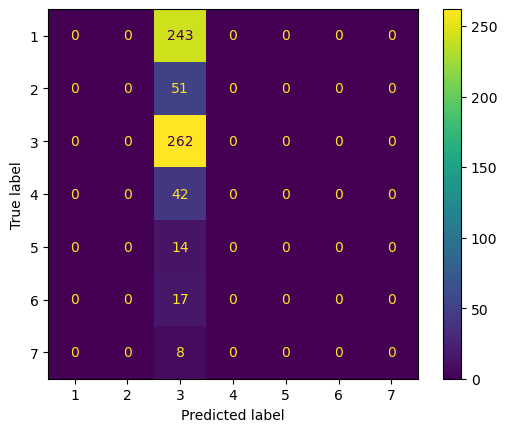

Accuracy Simple Deep Learning model:  0.41130298273155413


In [90]:
y_pred_mbn = np.array(np.argmax(y_pred_mbn_p, axis=1)).astype(int)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_mbn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_mbn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

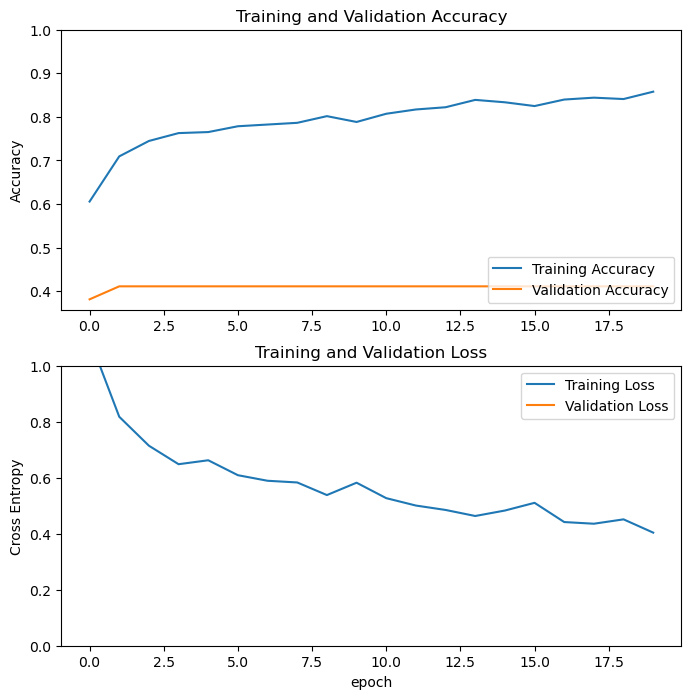

In [91]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Step 7. Recurrent Neural Networks (RNNs) classification

Recurrent Neural Networks (RNNs): RNNs can be used to analyze sequential data such as time series data, which can be useful for analyzing the temporal information present in Sentinel-2 imagery.

In [40]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 40

units = 64


# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(kernel*kernel, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(kernel*kernel, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model

In [41]:
RNNs_model = build_model(allow_cudnn_kernel=True)

RNNs_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


history5=RNNs_model.fit(
    X_train_nn, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20)],  verbose=0, validation_data=(X_val_nn, Y_val), batch_size=batch_size
)

Epoch 1/100


2023-01-22 05:18:50.514146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-22 05:18:50.699635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-22 05:18:51.022268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-22 05:18:53.209699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-22 05:18:53.291238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 4s 104ms/sample - loss: 1.7182 - accuracy: 0.4295 - val_loss: 1.9706 - val_accuracy: 0.4364
Epoch 21/100
40/40 [==============================] - 1s 33ms/sample - loss: 0.7383 - accuracy: 0.7405 - val_loss: 2.2951 - val_accuracy: 0.4631
Epoch 41/100
40/40 [==============================] - 1s 32ms/sample - loss: 0.6587 - accuracy: 0.7644 - val_loss: 2.0395 - val_accuracy: 0.4945
Epoch 61/100
40/40 [==============================] - 1s 32ms/sample - loss: 0.6247 - accuracy: 0.7731 - val_loss: 0.7785 - val_accuracy: 0.7221
Epoch 81/100
40/40 [==============================] - 1s 32ms/sample - loss: 0.5929 - accuracy: 0.7821 - val_loss: 1.2283 - val_accuracy: 0.5981


In [42]:
y_pred_rnn_p = RNNs_model.predict(X_val_nn)

print("Prediction example: ", y_pred_rnn_p[0,:], " Class: ", np.argmax(y_pred_rnn_p[0,:]))

2023-01-22 05:29:49.763819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-22 05:29:49.845120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 21ms/step
Prediction example:  [-3.705237   -0.01828903  4.28821    -5.04365     2.0257232   1.6866693
  2.2052958   1.6525115 ]  Class:  2


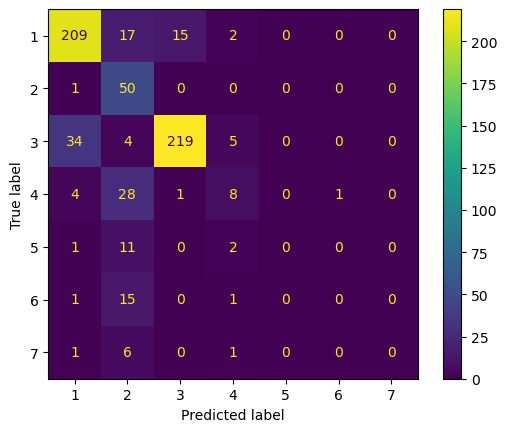

Accuracy Simple Deep Learning model:  0.7629513343799058


In [43]:
y_pred_rnn = np.argmax(y_pred_rnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_rnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

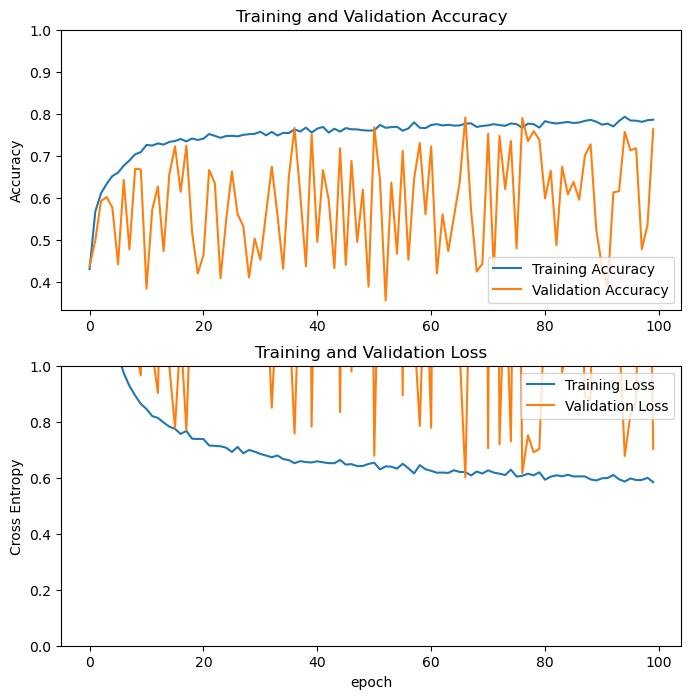

In [44]:

acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()